In [1]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:85% !important; }</style>"))

In [1]:
import numpy as np #    
import matplotlib
import tkinter
import math

import matplotlib.pyplot as plt #                                                              +                        
import cv2
import ipywidgets as widgets
from PIL import ImageEnhance
from PIL import Image # отрисовка изображений

from skimage import io, color
from skimage import util
from IPython.display import display

import matplotlib.image as mpimg 
import os
from tensorflow.keras.preprocessing import image

import pydicom
from skimage.transform import rotate
from skimage.transform import resize
from skimage import exposure
import tifffile
import pandas as pd
import shutil
import copy


In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.options.display.expand_frame_repr = False # чтобы датафрейм не подстраивался и использовал всю доступную ширину

pd.set_option('display.max_colwidth', 15)
pd.set_option('display.width', 1000)


<h1 style="color:Blue;">1. Создание категорийного (патология) датафрейма</h1>

In [3]:
import os
import pydicom
import numpy as np
import pandas as pd
import shutil

# 1) Получение списка наименований внутренних папок
def get_subfolder_names(root_folder):
    return [name for name in os.listdir(root_folder) if os.path.isdir(os.path.join(root_folder, name))]

# 2) Чтение всех DICOM файлов во внутренних папках и получение их позиции и изображения
def read_dicom_files(folder_path):
    dicom_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.dcm')]
    dicom_files.sort()  # Убедимся, что они отсортированы по имени
    slices = []
    for file in dicom_files:
        ds = pydicom.dcmread(file)
        img = ds.pixel_array
        position = ds.ImagePositionPatient if 'ImagePositionPatient' in ds else None
        slices.append((position, img))
    return slices

# 3) Создание списка объемных массивов из нормализованных изображений каждой внутренней папки
def normalize_images(slices):
    images = np.stack([s[1] for s in slices])
    normalized_images = images
    return normalized_images

# 4) Создание списков стандартных проекций по осям X, Y, Z
def create_projections(volume):
    projection_z = np.max(volume, axis=0)
    projection_y = np.max(volume, axis=1)
    projection_x = np.max(volume, axis=2)
    return projection_x, projection_y, projection_z

# Основная функция для выполнения всей задачи
def process_dicom_folders(root_folder):
    subfolders = get_subfolder_names(root_folder)
    volumetric_data = []

    for subfolder in subfolders:
        subfolder_path = os.path.join(root_folder, subfolder)
        slices = read_dicom_files(subfolder_path)
        volume = normalize_images(slices)
        projection_x, projection_y, projection_z = create_projections(volume)
        volumetric_data.append({
            "folder": subfolder,
            "volume": volume,
            "projection_x": projection_x,
            "projection_y": projection_y,
            "projection_z": projection_z
        })

    df = pd.DataFrame(volumetric_data)
    return df

# Укажите путь к корневой папке
root_folder = 'D:/AleksandrovTI/PP_700'
df = process_dicom_folders(root_folder)

pd.set_option('display.max_colwidth', 12)
pd.set_option('display.max_rows', 100)

df

# Сохранение DataFrame в файл
#df.to_pickle('dicom_data.pkl')

,folder,volume,projection_x,projection_y,projection_z
0,10(2),"[[[7159,...","[[7242, ...","[[8649, ...","[[7291, ..."
1,13(2),"[[[7190,...","[[7240, ...","[[7284, ...","[[7282, ..."
2,14(2),"[[[7155,...","[[7235, ...","[[8335, ...","[[7318, ..."
3,18(2),"[[[7194,...","[[7292, ...","[[7248, ...","[[7280, ..."
4,20(2),"[[[7203,...","[[7245, ...","[[8718, ...","[[7293, ..."
5,23(2),"[[[7248,...","[[7459, ...","[[7295, ...","[[7328, ..."
6,30(2),"[[[7197,...","[[7271, ...","[[8463, ...","[[7344, ..."
7,34(2),"[[[7199,...","[[7241, ...","[[8388, ...","[[7463, ..."
8,35(2),"[[[7179,...","[[7266, ...","[[8668, ...","[[7259, ..."
9,40(2),"[[[0, 0,...","[[7313, ...","[[7285, ...","[[0, 0, ..."


<h4 style="color:Blue;">1.2 Поменять местами высоту и ширину в двумерных массивах</h4>

In [4]:
# Поменять местами высоту и ширину в массивах
df['projection_x'] = df['projection_x'].apply(lambda arr: np.transpose(arr))
df['projection_y'] = df['projection_y'].apply(lambda arr: np.transpose(arr))

<h4 style="color:Blue;">1.3 Зеркально отразить массивы</h4>

In [5]:
# Поменять местами высоту и ширину в массивах
df['projection_x'] = df['projection_x'].apply(lambda arr: np.flip(arr, axis=1))
df['projection_y'] = df['projection_y'].apply(lambda arr: np.flip(arr, axis=1))

<h4 style="color:Blue;">1.4 Значения в элементах массивов в столбцах</h4>

In [6]:
# Определение максимального и минимального значений
max_value = np.max([np.max(arr) for arr in df['projection_x']])
min_value = np.min([np.min(arr) for arr in df['projection_x']])

print(f"Максимальное значение: {max_value}")
print(f"Минимальное значение: {min_value}")

Максимальное значение: 54262
Минимальное значение: 7209


In [7]:
# Определение максимального и минимального значений
max_value = np.max([np.max(arr) for arr in df['projection_y']])
min_value = np.min([np.min(arr) for arr in df['projection_y']])

print(f"Максимальное значение: {max_value}")
print(f"Минимальное значение: {min_value}")

Максимальное значение: 54262
Минимальное значение: 7210


<h1 style="color:Blue;">2. Нахождение файлов с протезами</h1>

<h3 style="color:Blue;">2.1 Удаление строк с яркостью менее 40000 единиц в пикселе</h3>

<h4 style="color:Blue;">'2.1.1 projection_y'</h4>

In [8]:
df = df[df['projection_y'].apply(lambda x: (x >= 40000).any())]

In [9]:
df

,folder,volume,projection_x,projection_y,projection_z
2,14(2),"[[[7155,...","[[7237, ...","[[8668, ...","[[7318, ..."
5,23(2),"[[[7248,...","[[7250, ...","[[8570, ...","[[7328, ..."
7,34(2),"[[[7199,...","[[7248, ...","[[8660, ...","[[7463, ..."
14,56(2),"[[[7160,...","[[7256, ...","[[8611, ...","[[7328, ..."


<h4 style="color:Blue;">'2.1.2 projection_x'</h4>

In [10]:
df = df[df['projection_x'].apply(lambda x: (x >= 40000).any())]

In [11]:
df

,folder,volume,projection_x,projection_y,projection_z
2,14(2),"[[[7155,...","[[7237, ...","[[8668, ...","[[7318, ..."
5,23(2),"[[[7248,...","[[7250, ...","[[8570, ...","[[7328, ..."
7,34(2),"[[[7199,...","[[7248, ...","[[8660, ...","[[7463, ..."
14,56(2),"[[[7160,...","[[7256, ...","[[8611, ...","[[7328, ..."


<h1 style="color:Blue;">3. Создание трехмерноо массива</h1>

In [12]:
directory = 'D:/AleksandrovTI/PP_7003/34(2)'
files = [f for f in os.listdir(directory) if f.endswith('.dcm')]
files.sort()

def read_dicom(file_path):
    dcm = pydicom.dcmread(file_path)
    image = dcm.pixel_array
    
    if 'ImagePositionPatient' in dcm:
        position = dcm.ImagePositionPatient
    elif 'InstanceNumber' in dcm:
        position = [0, 0, dcm.InstanceNumber]  # Выделяем позицию по InstanceNumber
    elif 'SliceLocation' in dcm:
        position = [0, 0, dcm.SliceLocation]  # Выделяем позицию по SliceLocation
    else:
        raise AttributeError(f"File {file_path} lacks position information.")
    
    return image, position

# Читаем все DICOM файлы и получаем их позицию и изображение
slices = [read_dicom(os.path.join(directory, f)) for f in files]
slices.sort(key=lambda s: s[1][2])  # Сортируем по Z координате (или ее альтернативе)

# Создаем объемный массив из нормализованных изображений
volume34 = np.stack([s[0] for s in slices], axis=-1)
print(volume34.shape)

(512, 512, 796)


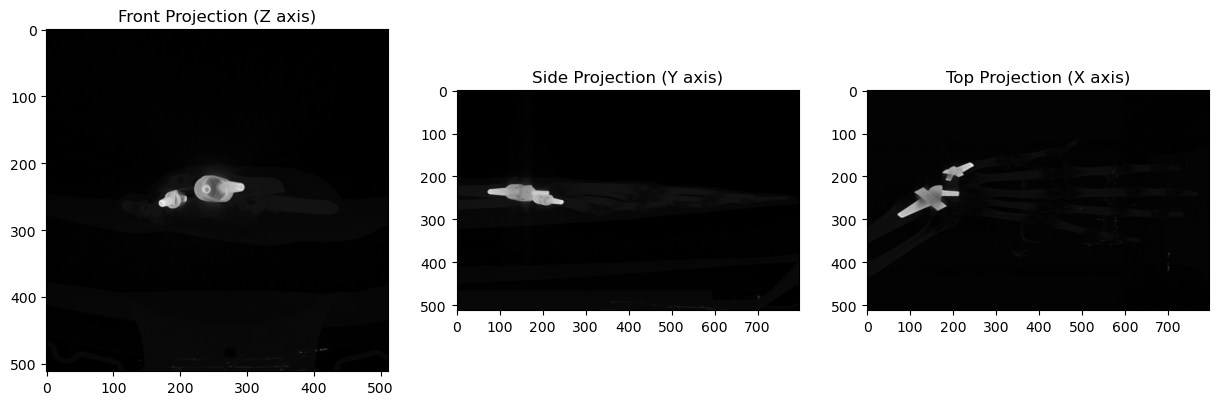

In [13]:
projection_z34 = np.max(volume34, axis=2) # Front projection (по оси Z)
projection_y34 = np.max(volume34, axis=1) # Side projection (по оси Y)
projection_x34 = np.max(volume34, axis=0) # Top projection (по оси X)

fig, axs = plt.subplots(1, 3, figsize=(15, 5)) # Визуализация проекций

axs[0].imshow(projection_z34, cmap='gray')
axs[0].set_title('Front Projection (Z axis)')

axs[1].imshow(projection_y34, cmap='gray')
axs[1].set_title('Side Projection (Y axis)')

axs[2].imshow(projection_x34, cmap='gray')
axs[2].set_title('Top Projection (X axis)')

plt.show()

In [14]:
# Top projection (по оси X)
projection_y34 = np.max(volume34, axis=1)
tifffile.imwrite('01_projection_y34.tiff', projection_y34) # Сохранение массива в TIFF-файл

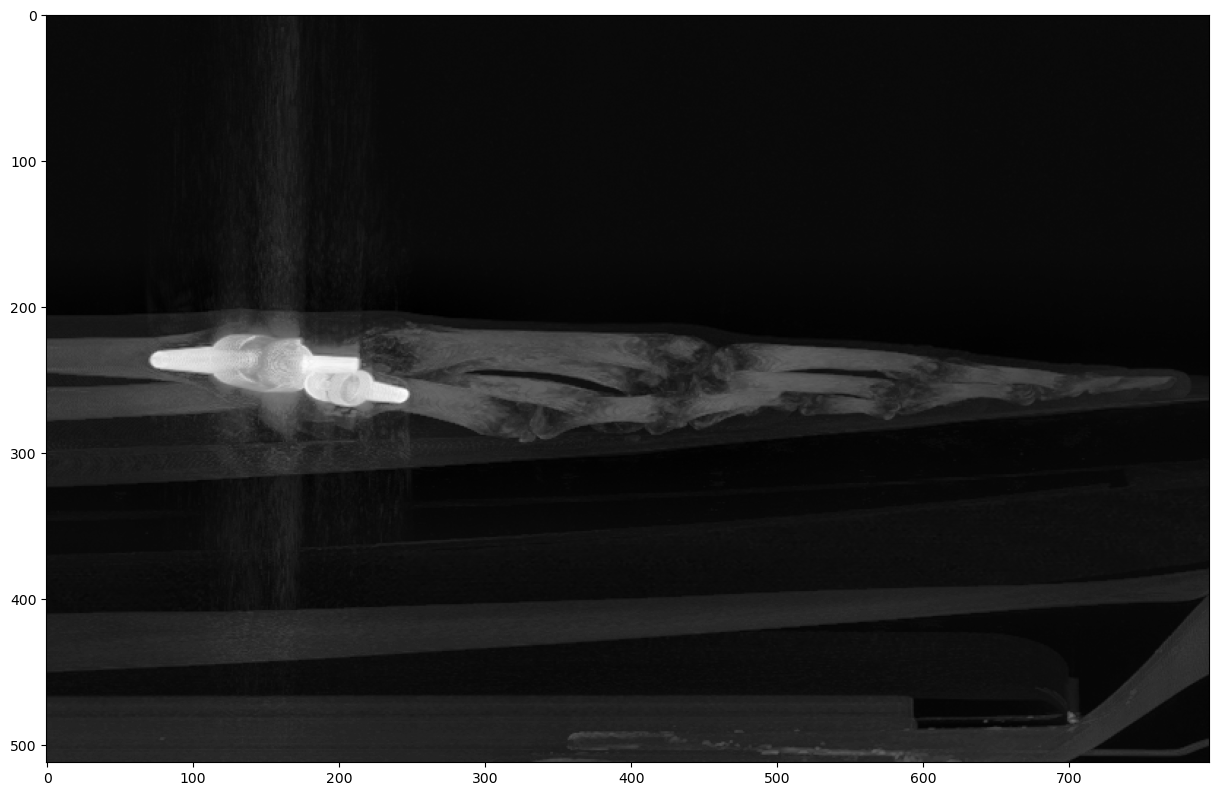

In [15]:
def apply_clahe(img):
    # Создание объекта CLAHE
    clahe = cv2.createCLAHE(clipLimit = 15.0, tileGridSize=(8, 8))
    
    # Если изображение цветное, применяем CLAHE для каждого канала YUV
    if len(img.shape) == 3 and img.shape[2] == 3:
        img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        img_yuv[:, :, 0] = clahe.apply(img_yuv[:, :, 0])
        img_clahe = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    elif len(img.shape) == 2:  # Если изображение одноцветное
        img_clahe = clahe.apply(img)
    else:
        img_clahe = img
    
    return img_clahe


# Отображение изображения
image = tifffile.imread('01_projection_y34.tiff')
 # Применение CLAHE для улучшения контраста
img_clahe = apply_clahe(image)

plt.figure(figsize=(15, 15))

plt.imshow(img_clahe, cmap='gray')
#plt.axis('off')
plt.show()

In [16]:
# Top projection (по оси X)
projection_x34 = np.max(volume34, axis=0)
tifffile.imwrite('01_projection_x34.tiff', projection_x34) # Сохранение массива в TIFF-файл

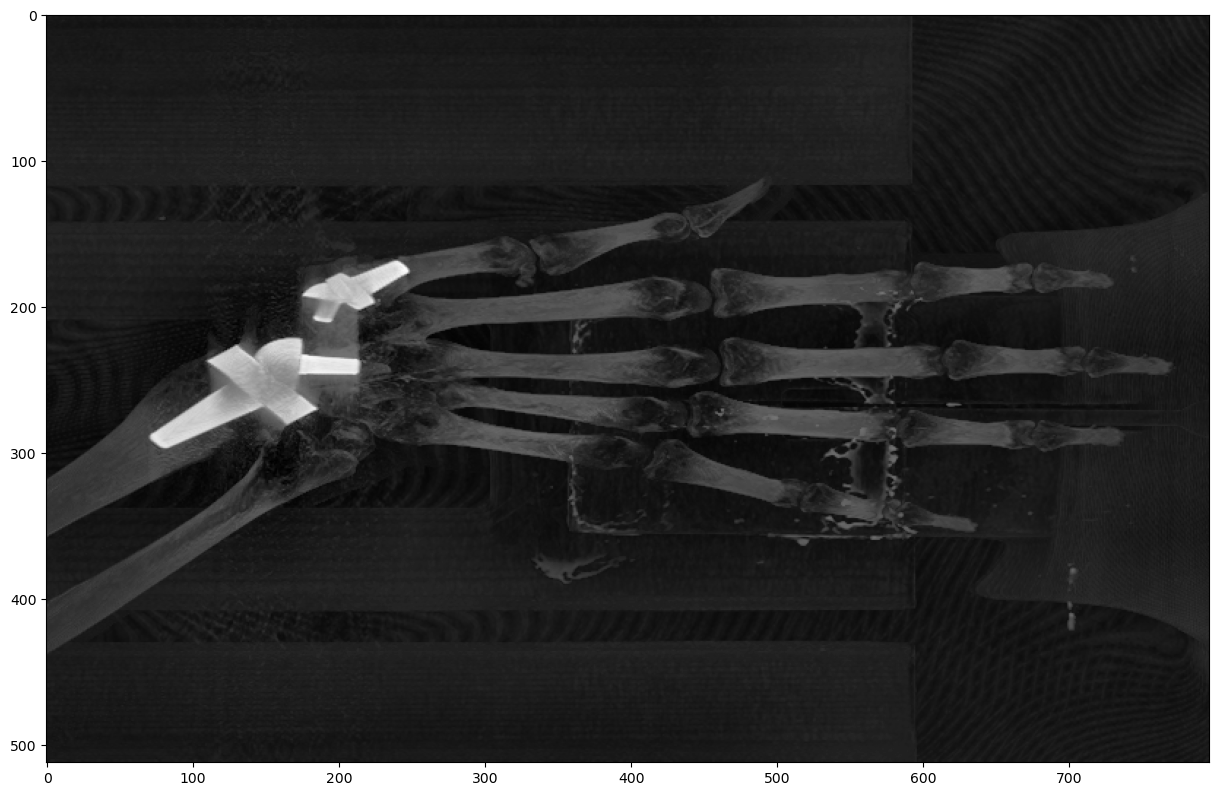

In [17]:
def apply_clahe(img):
    # Создание объекта CLAHE
    clahe = cv2.createCLAHE(clipLimit = 15.0, tileGridSize=(8, 8))
    
    # Если изображение цветное, применяем CLAHE для каждого канала YUV
    if len(img.shape) == 3 and img.shape[2] == 3:
        img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        img_yuv[:, :, 0] = clahe.apply(img_yuv[:, :, 0])
        img_clahe = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    elif len(img.shape) == 2:  # Если изображение одноцветное
        img_clahe = clahe.apply(img)
    else:
        img_clahe = img
    
    return img_clahe


# Отображение изображения
image = tifffile.imread('01_projection_x34.tiff')
 # Применение CLAHE для улучшения контраста
img_clahe = apply_clahe(image)

plt.figure(figsize=(15, 15))

plt.imshow(img_clahe, cmap='gray')
#plt.axis('off')
plt.show()

<h1 style="color:Blue;">4. Первый поворот</h1>

In [18]:
import cv2
import numpy as np

# Функция для изменения яркости и контрастности изображения
def adjust_brightness_contrast(image, brightness=10, contrast=150):
    beta = brightness
    alpha = contrast / 100.0
    new_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return new_image

# Чтение изображения
image = cv2.imread('01_projection_x34.tiff')
if image is None:
    raise ValueError(f'Не удалось загрузить изображение по указанному пути')

# Коррекция яркости и контрастности
image = adjust_brightness_contrast(image, brightness=40, contrast=450)

# Создание холста для отрисовки линий
overlay = image.copy()

# Список для хранения координат кликов
clicks = []
angles = []  # Список для хранения углов
angle = None  # Глобальная переменная для хранения угла

drawing = False

# Функция для записи угла в файл
def save_angle_to_file(angle, filename='angles.txt'):
    with open(filename, 'a') as f:
        f.write(f'{angle:.2f} градусов\n')

# Обработчик событий мыши
def mouse_callback(event, x, y, flags, param):
    global clicks, drawing, overlay, angle
    
    if event == cv2.EVENT_LBUTTONDOWN:
        clicks.append((x, y))

        if len(clicks) == 2:
            # Построить прямую линию №1, проходящую через ВСЁ изображение
            p1, p2 = clicks
            slope = (p2[1] - p1[1]) / (p2[0] - p1[0])
            intercept = p1[1] - slope * p1[0]

            x_coords = np.array([0, image.shape[1]])
            y_coords = slope * x_coords + intercept
            cv2.line(overlay, (x_coords[0], int(y_coords[0])), (x_coords[1], int(y_coords[1])), (255, 0, 0), 2)
            
            drawing = True

            # Вычисление угла между линией №1 и горизонтом
            angle = np.degrees(np.arctan2(slope, 1))

            # Проверка положения горизонтальной линии относительно линии №1
            if p1[1] < y_coords[0]:
                # Горизонтальная линия выше линии №1
                angle = abs(angle)
            else:
                # Горизонтальная линия ниже линии №1
                angle = -abs(angle)

            angles.append(angle)

            print(f'Угол между линией №1 и горизонтом: {angle:.2f} градусов')

            # Вывод угла на изображение
            cv2.putText(overlay, f"{angle:.2f} deg", (10, image.shape[0] - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            save_angle_to_file(angle)  # Запись угла в файл

        elif len(clicks) == 3:
            # Построить горизонтальную линию через третий клик
            p3 = clicks[2]
            cv2.line(overlay, (0, p3[1]), (image.shape[1], p3[1]), (0, 255, 0), 2)
            print(f'Горизонтальная линия нарисована через точку: {p3}')

# Привязка обработчика событий к окну изображения
cv2.namedWindow('Изображение')
cv2.setMouseCallback('Изображение', mouse_callback)

# Отображение изображения с наложенными линиями
while True:
    cv2.imshow('Изображение', overlay)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

# Сохранение измененного изображения
cv2.imwrite('01_projection_x34_angle.tiff', overlay)

cv2.destroyAllWindows()

print(f'Углы, сохраненные в программе: {angles}')


Угол между линией №1 и горизонтом: 31.82 градусов
Углы, сохраненные в программе: [31.81885392834025]


In [19]:
a1 = angle
a1

31.81885392834025

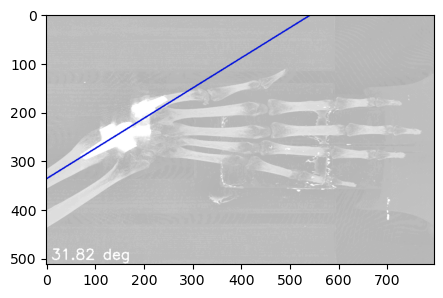

In [20]:
def apply_clahe(img):
    # Создание объекта CLAHE
    clahe = cv2.createCLAHE(clipLimit = 1.0, tileGridSize=(8, 8))
    
    # Если изображение цветное, применяем CLAHE для каждого канала YUV
    if len(img.shape) == 3 and img.shape[2] == 3:
        img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        img_yuv[:, :, 0] = clahe.apply(img_yuv[:, :, 0])
        img_clahe = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    elif len(img.shape) == 2:  # Если изображение одноцветное
        img_clahe = clahe.apply(img)
    else:
        img_clahe = img
    
    return img_clahe


# Отображение изображения
image = tifffile.imread('01_projection_x34_angle.tiff')
 # Применение CLAHE для улучшения контраста
img_clahe = apply_clahe(image)

plt.figure(figsize=(5, 5))

plt.imshow(img_clahe, cmap='gray')
#plt.axis('off')
plt.show()

Original volume shape: (512, 512, 796)
Rotated volume shape: (512, 512, 796)


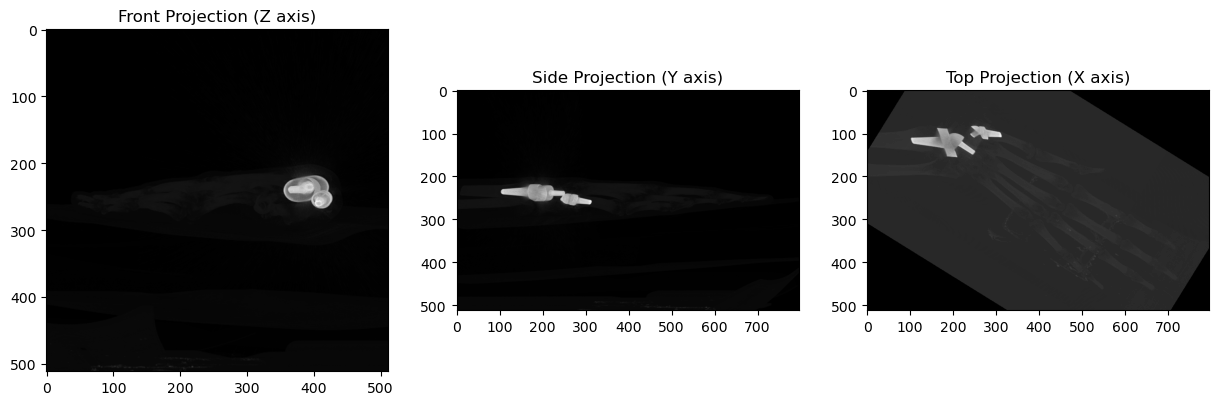

In [21]:
import os
import numpy as np
import pydicom
from skimage import exposure
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

def read_dicom_images(directory):
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.dcm')]
    files.sort()
    slices = [pydicom.dcmread(f).pixel_array for f in files]
    volume = np.stack(slices, axis=-1)
    return volume

def rotate_volume(volume, angle):
    # Поворот объёма вокруг оси Z
    rotated_volume = rotate(volume, angle, axes=(1, 2), reshape=False)
    return rotated_volume

def get_projections(volume):
    projection_xx = np.flip(np.max(volume, axis=0), axis=1)
    projection_yy = np.flip(np.max(volume, axis=1), axis=1)
    projection_zz = np.flip(np.max(volume, axis=2), axis=1)
    return projection_xx, projection_yy, projection_zz

# Путь к директории с DICOM изображениями
directory = 'D:/AleksandrovTI/PP_7003/34(2)'

# Чтение и нормализация изображения
volume = read_dicom_images(directory)
#volume_normalized = normalize_images(volume)
print("Original volume shape:", volume.shape)

# Угол поворота 
angle = a1

# Поворот объёма вокруг оси Z
rotated_volume34 = rotate_volume(volume, angle)
print("Rotated volume shape:", rotated_volume34.shape)

# Получение проекций после поворота
projection_xr, projection_yr, projection_zr = get_projections(rotated_volume34)

# Визуализация проекций
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(projection_zr, cmap='gray')
axs[0].set_title('Front Projection (Z axis)')

axs[1].imshow(projection_yr, cmap='gray')
axs[1].set_title('Side Projection (Y axis)')

axs[2].imshow(projection_xr, cmap='gray')
axs[2].set_title('Top Projection (X axis)')

plt.show()


<h1 style="color:Blue;">5. Второй поворот</h1>

In [22]:
# Side Projection (Y axis)
projection_yr = np.max(rotated_volume34, axis=1)

projection_yr = np.flip(projection_yr, axis=1) # ИСПРАВЛЕНИЕ ВЫВОДА ЗЕРКАЛЬНОГО ИЗОБРАЖЕНИЯ
tifffile.imwrite('03_projection_yr34.tiff', projection_yr)

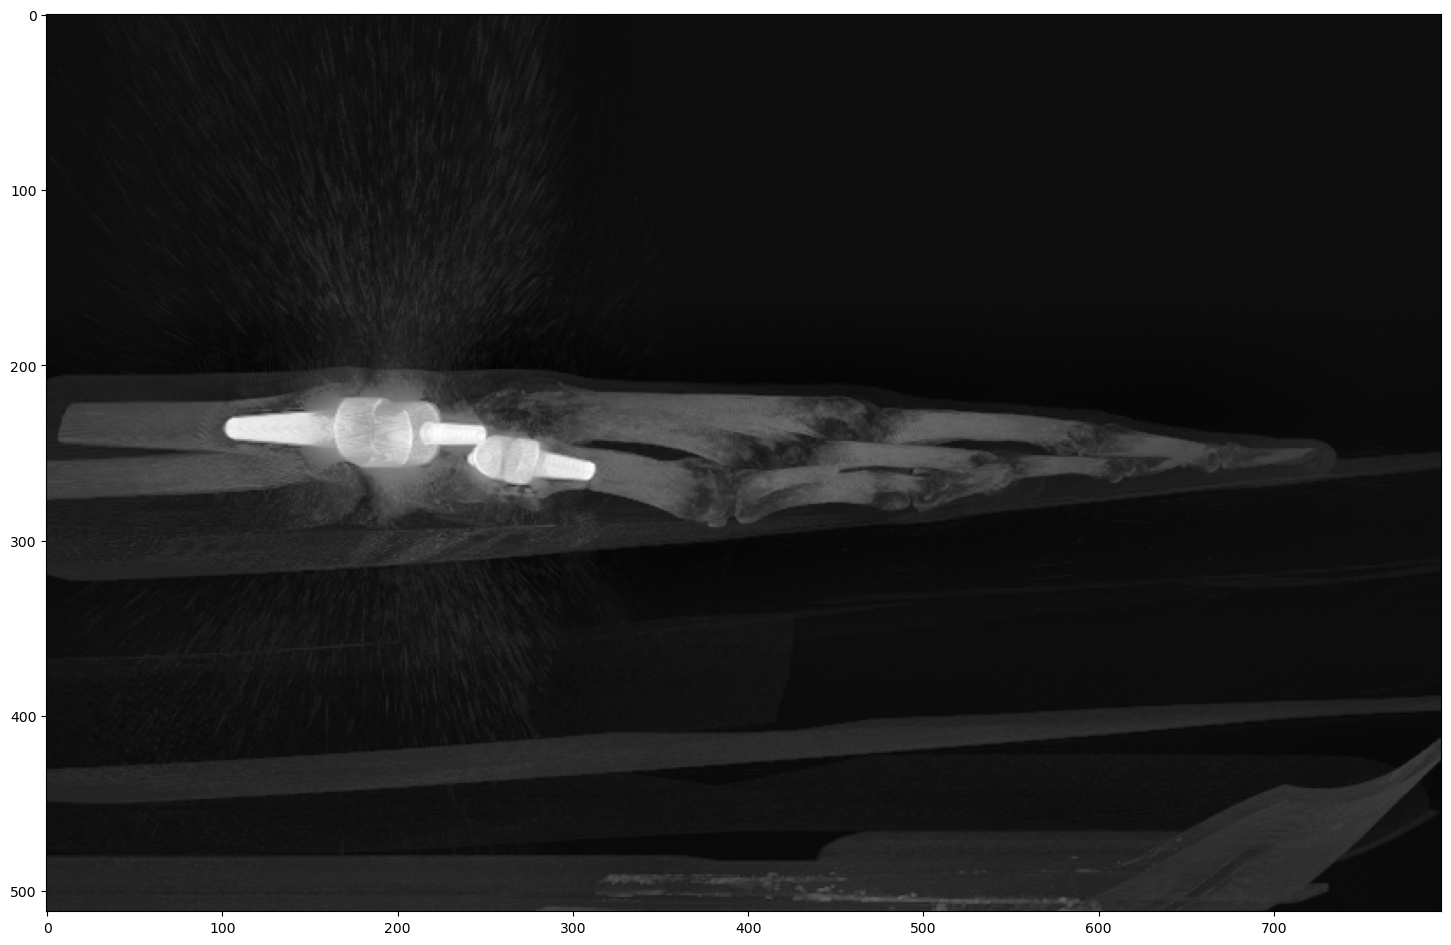

In [23]:
def apply_clahe(img):
    # Создание объекта CLAHE
    clahe = cv2.createCLAHE(clipLimit = 15.0, tileGridSize=(8, 8))
    
    # Если изображение цветное, применяем CLAHE для каждого канала YUV
    if len(img.shape) == 3 and img.shape[2] == 3:
        img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        img_yuv[:, :, 0] = clahe.apply(img_yuv[:, :, 0])
        img_clahe = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    elif len(img.shape) == 2:  # Если изображение одноцветное
        img_clahe = clahe.apply(img)
    else:
        img_clahe = img
    
    return img_clahe


# Отображение изображения
image = tifffile.imread('03_projection_yr34.tiff')
 # Применение CLAHE для улучшения контраста
img_clahe = apply_clahe(image)

plt.figure(figsize=(18, 18))

plt.imshow(img_clahe, cmap='gray')
#plt.axis('off')
plt.show()

In [24]:
import cv2
import numpy as np

# Функция для изменения яркости и контрастности изображения
def adjust_brightness_contrast(image, brightness=10, contrast=150):
    beta = brightness
    alpha = contrast / 100.0
    new_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return new_image

# Чтение изображения
image = cv2.imread('03_projection_yr34.tiff')
if image is None:
    raise ValueError(f'Не удалось загрузить изображение по указанному пути')

# Коррекция яркости и контрастности
image = adjust_brightness_contrast(image, brightness=40, contrast=450)

# Создание холста для отрисовки линий
overlay = image.copy()

# Список для хранения координат кликов
clicks = []
angles = []  # Список для хранения углов
angle = None  # Глобальная переменная для хранения угла

drawing = False

# Функция для записи угла в файл
def save_angle_to_file(angle, filename='angles.txt'):
    with open(filename, 'a') as f:
        f.write(f'{angle:.2f} градусов\n')

# Обработчик событий мыши
def mouse_callback(event, x, y, flags, param):
    global clicks, drawing, overlay, angle
    
    if event == cv2.EVENT_LBUTTONDOWN:
        clicks.append((x, y))

        if len(clicks) == 2:
            # Построить прямую линию №1, проходящую через ВСЁ изображение
            p1, p2 = clicks
            slope = (p2[1] - p1[1]) / (p2[0] - p1[0])
            intercept = p1[1] - slope * p1[0]

            x_coords = np.array([0, image.shape[1]])
            y_coords = slope * x_coords + intercept
            cv2.line(overlay, (x_coords[0], int(y_coords[0])), (x_coords[1], int(y_coords[1])), (255, 0, 0), 2)
            
            drawing = True

            # Вычисление угла между линией №1 и горизонтом
            angle = np.degrees(np.arctan2(slope, 1))

            # Проверка положения горизонтальной линии относительно линии №1
            if p1[1] < y_coords[0]:
                # Горизонтальная линия выше линии №1
                angle = abs(angle)
            else:
                # Горизонтальная линия ниже линии №1
                angle = -abs(angle)

            angles.append(angle)

            print(f'Угол между линией №1 и горизонтом: {angle:.2f} градусов')

            # Вывод угла на изображение
            cv2.putText(overlay, f"{angle:.2f} deg", (10, image.shape[0] - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            save_angle_to_file(angle)  # Запись угла в файл

        elif len(clicks) == 3:
            # Построить горизонтальную линию через третий клик
            p3 = clicks[2]
            cv2.line(overlay, (0, p3[1]), (image.shape[1], p3[1]), (0, 255, 0), 2)
            print(f'Горизонтальная линия нарисована через точку: {p3}')

# Привязка обработчика событий к окну изображения
cv2.namedWindow('Изображение')
cv2.setMouseCallback('Изображение', mouse_callback)

# Отображение изображения с наложенными линиями
while True:
    cv2.imshow('Изображение', overlay)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

# Сохранение измененного изображения
cv2.imwrite('04_projection_yr34_angle.tiff', overlay)

cv2.destroyAllWindows()

print(f'Углы, сохраненные в программе: {angles}')


Угол между линией №1 и горизонтом: -1.33 градусов
Углы, сохраненные в программе: [-1.3322198538696388]


In [25]:
b1 = angle
b1

-1.3322198538696388

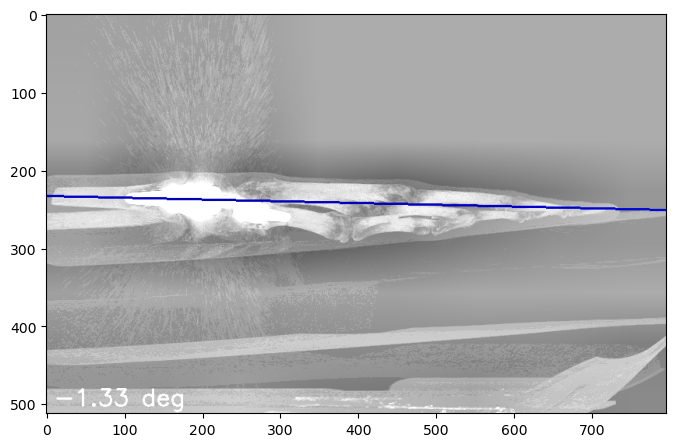

In [26]:
def apply_clahe(img):
    # Создание объекта CLAHE
    clahe = cv2.createCLAHE(clipLimit = 15.0, tileGridSize=(8, 8))
    
    # Если изображение цветное, применяем CLAHE для каждого канала YUV
    if len(img.shape) == 3 and img.shape[2] == 3:
        img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        img_yuv[:, :, 0] = clahe.apply(img_yuv[:, :, 0])
        img_clahe = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    elif len(img.shape) == 2:  # Если изображение одноцветное
        img_clahe = clahe.apply(img)
    else:
        img_clahe = img
    
    return img_clahe


# Отображение изображения
image = tifffile.imread('04_projection_yr34_angle.tiff')
 # Применение CLAHE для улучшения контраста
img_clahe = apply_clahe(image)

plt.figure(figsize=(8, 8))

plt.imshow(img_clahe, cmap='gray')
#plt.axis('off')
plt.show()

Rotated volume shape: (512, 512, 796)


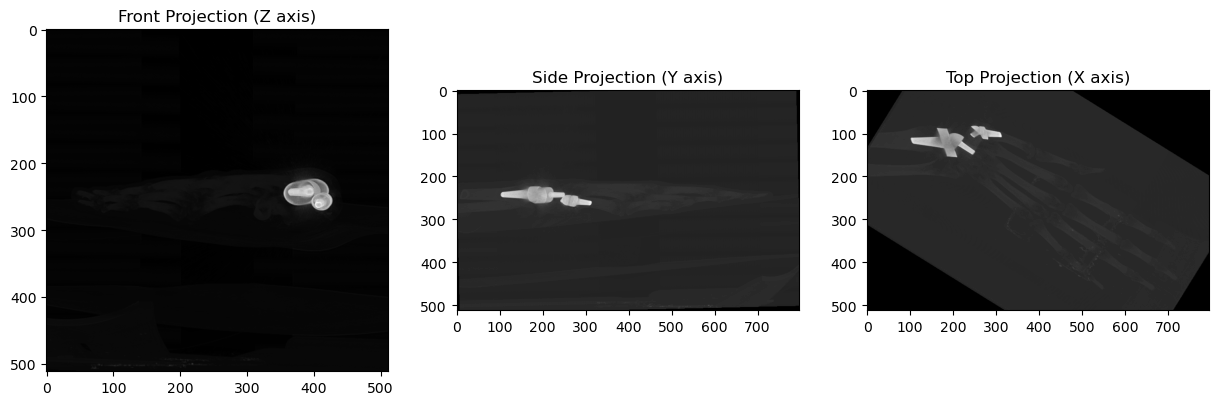

In [27]:
import os
import numpy as np
import pydicom
from skimage import exposure
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

def read_dicom_images(directory):
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.dcm')]
    files.sort()
    slices = [pydicom.dcmread(f).pixel_array for f in files]
    volume = np.stack(slices, axis=-1)
    return volume

def rotate_volume(volume, angle):
    # Поворот объёма вокруг оси Z
    rotated_volume = rotate(volume, angle, axes=(0, 2), reshape=False)
    return rotated_volume

def get_projections(volume):
    projection_xxx = np.flip(np.max(volume, axis=0), axis=1)
    projection_yyy = np.flip(np.max(volume, axis=1), axis=1)
    projection_zzz = np.flip(np.max(volume, axis=2), axis=1)
    return projection_xxx, projection_yyy, projection_zzz

# Угол поворота 
angle = b1

# Поворот объёма вокруг оси Y
twice_rotated_volume34 = rotate_volume(rotated_volume34, angle)
print("Rotated volume shape:", twice_rotated_volume34.shape)

# Получение проекций после ВТОРОГО поворота
projection_xrr, projection_yrr, projection_zrr = get_projections(twice_rotated_volume34)

# Визуализация проекций
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(projection_zrr, cmap='gray')
axs[0].set_title('Front Projection (Z axis)')

axs[1].imshow(projection_yrr, cmap='gray')
axs[1].set_title('Side Projection (Y axis)')

axs[2].imshow(projection_xrr, cmap='gray')
axs[2].set_title('Top Projection (X axis)')

plt.show()

<h1 style="color:Blue;">6. Вертикальное сечение</h1>

In [28]:
# Top projection (по оси X)
projection_xrr = np.max(twice_rotated_volume34, axis=0)
projection_xrr = np.flip(projection_xrr, axis=1)
tifffile.imwrite('05_projection34_xrr.tiff', projection_xrr) # Сохранение массива в TIFF-файл

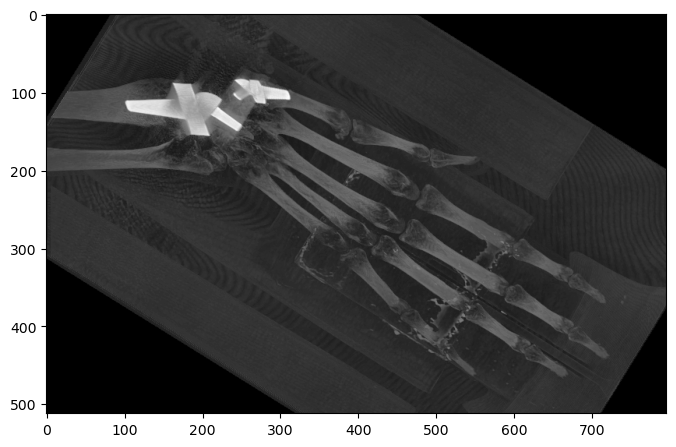

In [29]:
def apply_clahe(img):
    # Создание объекта CLAHE
    clahe = cv2.createCLAHE(clipLimit = 15.0, tileGridSize=(8, 8))
    
    # Если изображение цветное, применяем CLAHE для каждого канала YUV
    if len(img.shape) == 3 and img.shape[2] == 3:
        img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        img_yuv[:, :, 0] = clahe.apply(img_yuv[:, :, 0])
        img_clahe = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    elif len(img.shape) == 2:  # Если изображение одноцветное
        img_clahe = clahe.apply(img)
    else:
        img_clahe = img
    
    return img_clahe


# Отображение изображения
image = tifffile.imread('05_projection34_xrr.tiff')
 # Применение CLAHE для улучшения контраста
img_clahe = apply_clahe(image)

plt.figure(figsize=(8, 8))

plt.imshow(img_clahe, cmap='gray')
#plt.axis('off')
plt.show()

In [30]:
def adjust_brightness_contrast(image, brightness=50, contrast=50):
    beta = brightness
    alpha = contrast / 100.0
    new_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return new_image

# Чтение изображения
image = cv2.imread('05_projection34_xrr.tiff')

# Функция-обработчик события клика мыши
def mouse_callback(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        print(f"Координаты сечения по клику выбранной кости: ({x}, {y})")

# Создание окна и привязка обработчика события
cv2.namedWindow('Изображение')
cv2.setMouseCallback('Изображение', mouse_callback)

# Отображение изображения
while True:
    cv2.imshow('Изображение', image)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

cv2.destroyAllWindows()

Координаты сечения по клику выбранной кости: (92, 117)


In [31]:
vol = np.transpose(twice_rotated_volume34, (1, 2, 0))
vol.shape

(512, 796, 512)

In [32]:
pict = vol[117]
# Зеркальное отражение изображения слева направо
pict.shape

(796, 512)

In [33]:
pict1 = np.transpose(pict, (1, 0))
flipped_pict1 = np.flip(pict1, axis=1)
print(f"Исходный массив: {pict.shape}")
print(f"Преобразованный массив: {flipped_pict1.shape}")

Исходный массив: (796, 512)
Преобразованный массив: (512, 796)


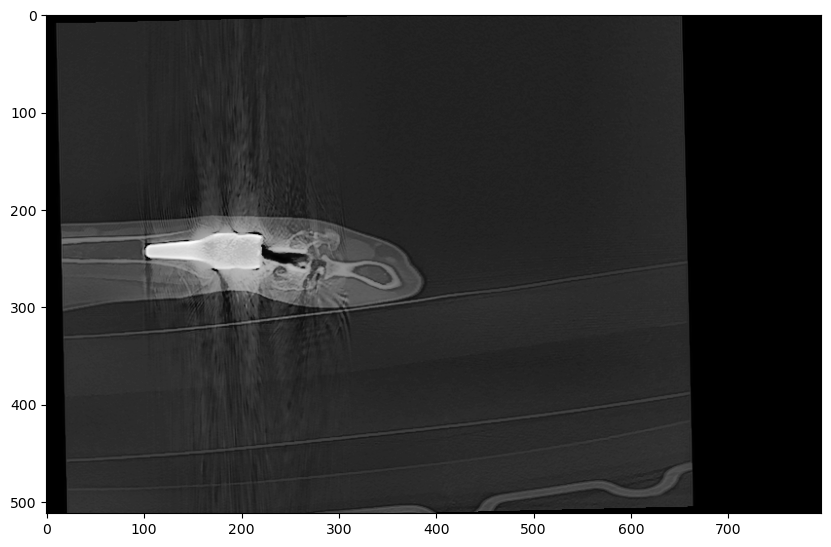

In [34]:
# Сохранение массива в TIFF-файл
tifffile.imwrite('06_from_pict_vert_34.tiff', flipped_pict1)
# Отображение изображения
def apply_clahe(img):
    # Создание объекта CLAHE
    clahe = cv2.createCLAHE(clipLimit = 25.0, tileGridSize=(8, 8))
    
    # Если изображение цветное, применяем CLAHE для каждого канала YUV
    if len(img.shape) == 3 and img.shape[2] == 3:
        img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        img_yuv[:, :, 0] = clahe.apply(img_yuv[:, :, 0])
        img_clahe = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    elif len(img.shape) == 2:  # Если изображение одноцветное
        img_clahe = clahe.apply(img)
    else:
        img_clahe = img
    
    return img_clahe


# Отображение изображения
image = tifffile.imread('06_from_pict_vert_34.tiff')
 # Применение CLAHE для улучшения контраста
img_clahe = apply_clahe(image)

plt.figure(figsize=(10, 10))

plt.imshow(img_clahe, cmap='gray')
#plt.axis('off')
plt.show()

<h1 style="color:Blue;">7. Горизонтальноее сечение</h1>

In [35]:
def adjust_brightness_contrast(image, brightness=50, contrast=50):
    beta = brightness
    alpha = contrast / 100.0
    new_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return new_image

# Чтение изображения
image = cv2.imread('06_from_pict_vert_34.tiff')
if image is None:
    raise ValueError(f'Не удалось загрузить изображение по пути')

# Коррекция яркости и контрастности
image = adjust_brightness_contrast(image, brightness=40, contrast=450)

# Функция-обработчик события клика мыши
def mouse_callback(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        print(f"Координаты сечения по клику выбранной кости: ({x}, {y})")

# Создание окна и привязка обработчика события
cv2.namedWindow('Изображение')
cv2.setMouseCallback('Изображение', mouse_callback)

# Отображение изображения
while True:
    cv2.imshow('Изображение', image)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

cv2.destroyAllWindows()

Координаты сечения по клику выбранной кости: (89, 242)


In [37]:
pictt1 = twice_rotated_volume34[239]
# Зеркальное отражение изображения слева направо
#flipped_pictt1 = np.flip(pictt1, axis=1)
flipped_pictt1 = np.transpose(pictt1, (1, 0))

pictt2 = twice_rotated_volume34[242]
# Зеркальное отражение изображения слева направо
#flipped_pictt2 = np.flip(pictt2, axis=1)
flipped_pictt2 = np.transpose(pictt2, (1, 0))

pictt3 = twice_rotated_volume34[245]
# Зеркальное отражение изображения слева направо
#flipped_pictt2 = np.flip(pictt2, axis=1)
flipped_pictt3 = np.transpose(pictt3, (1, 0))

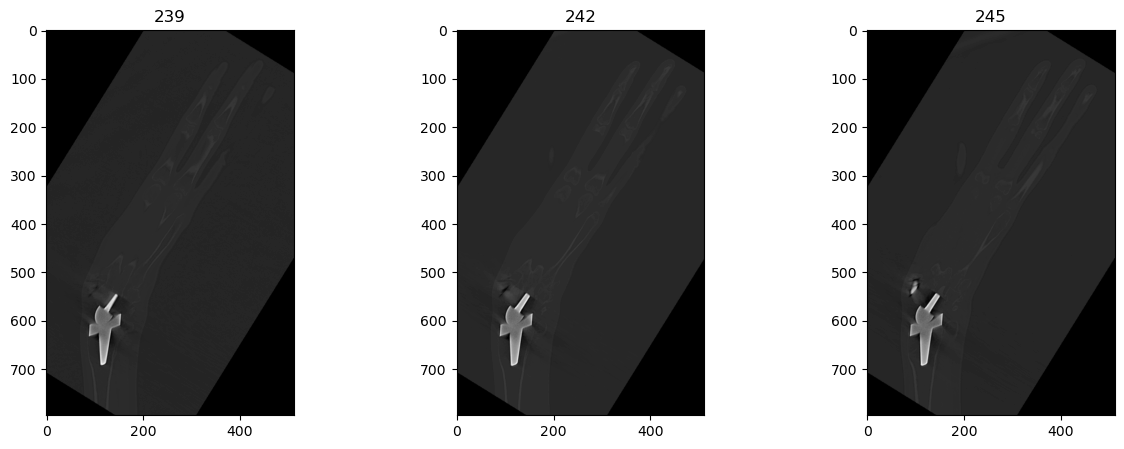

In [38]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5)) # Визуализация проекций

axs[0].imshow(flipped_pictt1, cmap='gray')
axs[0].set_title('239')

axs[1].imshow(flipped_pictt2, cmap='gray')
axs[1].set_title('242')

axs[2].imshow(flipped_pictt3, cmap='gray')
axs[2].set_title('245')

plt.show()

In [39]:
tifffile.imwrite('34_239.tiff', flipped_pictt1) # Сохранение массива в TIFF-файл
tifffile.imwrite('34_242.tiff', flipped_pictt2) # Сохранение массива в TIFF-файл
tifffile.imwrite('34_245.tiff', flipped_pictt3) # Сохранение массива в TIFF-файл

In [49]:
image = Image.open('34_239.tiff')

# размеры для обрезки
left = 75
top = 600
right = 350
bottom = 50

cropped_image = image.crop((left, top, image.width - right, image.height - bottom))

cropped_image.save('34_239_bw.tiff')

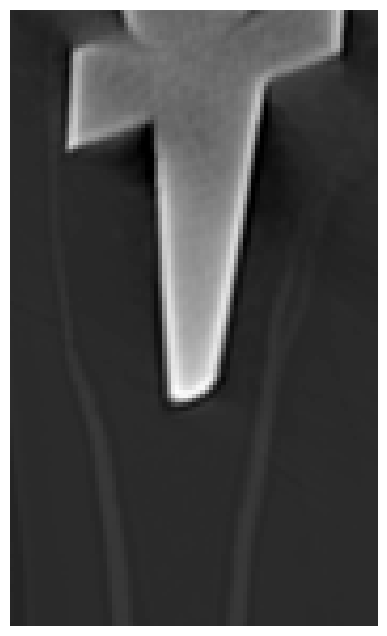

In [50]:
%matplotlib inline
gray_image282 = Image.open('34_239_bw.tiff')
plt.figure(figsize=(8, 8)) # Отображение изображения в оттенках серого
plt.imshow(gray_image282, cmap='gray')
plt.axis('off')
plt.show()

In [51]:
gray = Image.open('34_239_bw.tiff')
im = np.array(gray)
im.shape

(146, 87)

In [52]:
im.max()

48455

In [53]:
im.min()

0

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev
from PIL import Image, ImageDraw
import pandas as pd
import matplotlib
import tifffile

matplotlib.use('TkAgg')  # Используйте TkAgg backend
from matplotlib.backend_bases import MouseButton

ddf = pd.DataFrame(columns=['pixels_inside_curve'])

image_path = '34_239_bw.tiff'  # Путь к изображению
image_array = tifffile.imread(image_path)  # Чтение изображения в numpy массив
image_array = image_array.astype(np.int32)
# Преобразование numpy массива в объект PIL Image для дальнейшего использования
image = Image.fromarray(image_array).convert("RGBA")

# Определение размера изображения
height, width = [146,87]

# список для хранения точек
points = []

def onclick(event):
    line_image = create_line_image()
    save_combined_image(line_image)

# Обработчик кликов
def onclick(event):
    global points
    if event.button == MouseButton.LEFT:
        # Добавление точки в список
        points.append([event.xdata, event.ydata])
        
        # Отображение точки на изображении
        ax.plot(event.xdata, event.ydata, 'ro', markersize=3)
        fig.canvas.draw()
        
        # Когда было выбрано 31 точек или больше, нарисовать кривую линию
        if len(points) == 41:
            if points[0] != points[-1]:
                points.append(points[0])
            line_image = draw_spline(points)  # Теперь передаем line_image
            save_combined_image(line_image)
            save_line_image(line_image)  # Добавляем этот вызов
            save_internal_pixels_list(points, width, height)  # Передаем ширину и высоту
            fig.canvas.mpl_disconnect(cid)

# Функция для рисования кривой линии
def draw_spline(points):
    points = np.array(points)
    x = points[:, 0]
    y = points[:, 1]
    
    # Используем сплайны для плавной линии через контрольные точки
    tck, u = splprep([x, y], s=0)
    u_new = np.linspace(u.min(), u.max(), 1000)
    x_new, y_new = splev(u_new, tck, ext=0)
    
    ax.plot(x_new, y_new, 'r-', lw=1.2)  # Рисование линии
    fig.canvas.draw()

    # Создаем пустое изображение для линии
    line_image = Image.new("RGBA", (width, height), (0, 0, 0, 0))
    save_combined_image(line_image)
    draw = ImageDraw.Draw(line_image)
    line_points = list(zip(x_new, y_new))
    draw.line(line_points, fill=(255, 0, 0, 255), width=1)
    return line_image

# Функция для сохранения изображения с нанесённой линией
def save_combined_image(line_image):
    # Копируем исходное изображение
    combined_image = image.copy()
    combined_image = Image.alpha_composite(combined_image, line_image)
    combined_image.save("34_239_bw_line.tiff")
    #print("Изображение сохранено как 16_256_152_gilula_and_1_line.png")
    
# Функция для сохранения только линии в отдельный файл
def save_line_image(line_image):
    line_image.save("firs34_line_only.tiff")
    #print("Изображение линии сохранено как first_line_only.png")

# Функция для сохранения списка пикселей внутри замкнутой кривой линии
def save_internal_pixels_list(points, width, height):
    mask = Image.new("L", (width, height), 0)
    points = [(int(p[0]), int(p[1])) for p in points]
    ImageDraw.Draw(mask).polygon(points, outline=1, fill=1)
    mask = np.array(mask)
    
    internal_pixels = image_array[mask == 1]
    
    # Добавление списка пикселей в DataFrame
    ddf.loc[len(ddf)] = [internal_pixels.tolist()]
    print("Пиксели внутри замкнутой кривой линии добавлены в DataFrame")
    print(ddf)

# Создание фигуры и отображение изображения
fig, ax = plt.subplots()
ax.imshow(image_array)

# Привязка обработчика кликов
cid = fig.canvas.mpl_connect('button_press_event', onclick)

# Запуск обработки событий и отображение окна
plt.show()

Пиксели внутри замкнутой кривой линии добавлены в DataFrame
                                 pixels_inside_curve
0  [25869, 31245, 36461, 22807, 3917, 6151, 21106...


In [3]:
ddf

,pixels_inside_curve
0,"[25869, 31245, 36461, 22807, 3917, 6151, 21106..."


In [4]:
# Каличество пикселей
len(ddf.iloc[0,0])

2481

In [6]:
# СПИСОК
listic34 = ddf.iloc[0,0] # Список элементов
print(listic34[0:10])
print(min(listic34))
print(max(listic34))

[25869, 31245, 36461, 22807, 3917, 6151, 21106, 20889, 21125, 21867]
0
48455


<h1 style="color:Blue;">8. Распределение С ПРОТЕЗОМ (правая яркая часть)</h1>

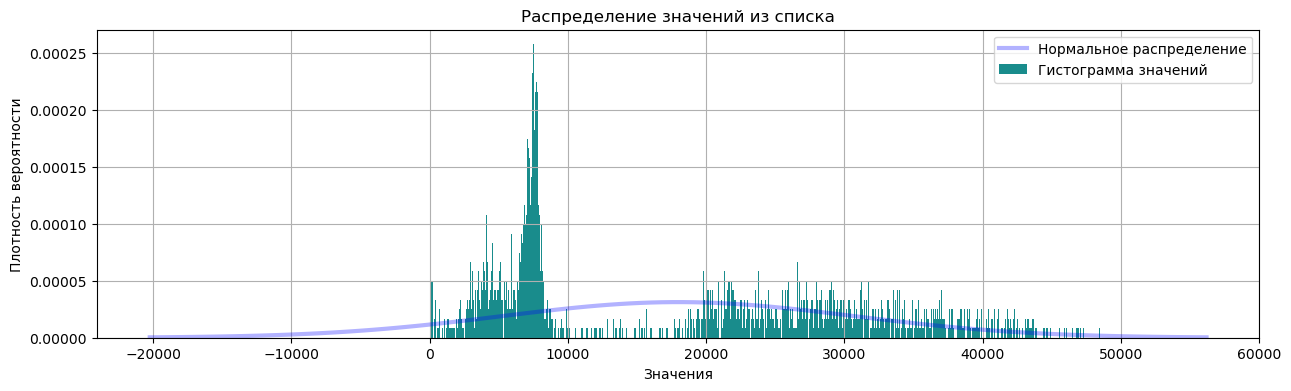

Эксцесс  -1.2257490656506922
Асимметрия  0.3756924330756769
Среднее значение пикселей: 17969.53365578396
Минимальное значение пикселей: 0
Максимальное значение пикселей: 48455
Три наиболее часто встречающихся значения:
Значение: 0, Частота: 15
Значение: 7367, Частота: 4
Значение: 4025, Частота: 3


In [7]:
from collections import Counter
from scipy.stats import kurtosis
from scipy.stats import skew
import statistics
import seaborn as sns
import scipy.stats as stats
%matplotlib inline
# Вычисление среднего и стандартного отклонения
mean = np.mean(listic34) ######################################################################
std_dev = np.std(listic34) ###############################################################################

# Генерация точек для построения нормального распределения
x = np.linspace(mean -3*std_dev, mean + 3*std_dev, 100)
y = stats.norm.pdf(x, mean, std_dev)


# Построение графика
plt.figure(figsize=(15, 4))
plt.plot(x, y, linewidth=3, color='b', label='Нормальное распределение', alpha=0.3)
plt.hist(listic34, density=True, bins=1000, alpha=0.9, color='Teal', label='Гистограмма значений') ############################


plt.title('Распределение значений из списка')
plt.xlabel('Значения')
plt.ylabel('Плотность вероятности')
plt.legend()
plt.grid()
plt.show()
print("Эксцесс ", kurtosis(listic34))######################################################
print("Асимметрия ", skew(listic34))####################################################

average = statistics.mean(listic34) #####################################################
print(f'Среднее значение пикселей: {average}') 

mi = min(listic34)##################################################################
print(f'Минимальное значение пикселей: {mi}') 
ma = max(listic34)###################################################################
print(f'Максимальное значение пикселей: {ma}') 

count = Counter(listic34)  ##################################################################
# Получение трех наиболее распространенных значений и их частоты
most_common_three = count.most_common(3)
print("Три наиболее часто встречающихся значения:")
for value, freq in most_common_three:
    print(f'Значение: {value}, Частота: {freq}')


<h1 style="color:Blue;">9. Распределение БЕЗ ПРОТЕЗА (яркие пиксели удалены)</h1>

In [8]:
import math
# Удаление элементов, превышающих 14000
listic34a = [x for x in listic34 if x <= 14000]
#listic23al = [math.log(x) for x in listic23a]

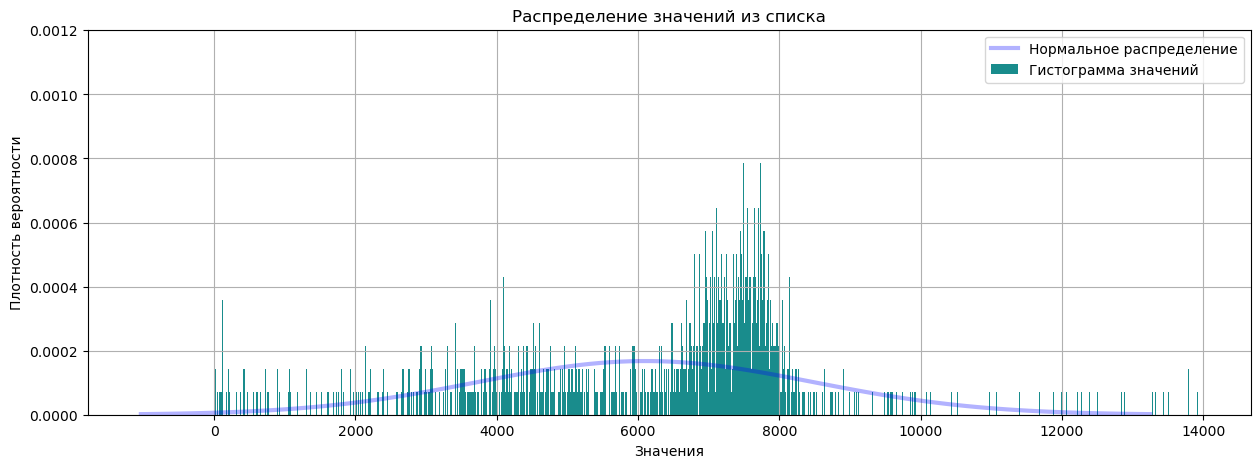

Эксцесс  0.8061092573930018
Асимметрия  -0.49244754654033784
Среднее значение пикселей: 6103.778423236515
Минимальное значение пикселей: 0
Минимальное значение пикселей: 13919
Три наиболее часто встречающихся значения:
Значение: 0, Частота: 15
Значение: 7367, Частота: 4
Значение: 4025, Частота: 3


In [9]:
from collections import Counter
from scipy.stats import kurtosis
from scipy.stats import skew
import statistics
import seaborn as sns
import scipy.stats as stats
%matplotlib inline
# Вычисление среднего и стандартного отклонения
mean = np.mean(listic34a) ######################################################################
std_dev = np.std(listic34a) ###############################################################################

# Генерация точек для построения нормального распределения
x = np.linspace(mean -3*std_dev, mean + 3*std_dev, 100)
y = stats.norm.pdf(x, mean, std_dev)


# Построение графика
plt.figure(figsize=(15, 5))
plt.plot(x, y, linewidth=3, color='b', label='Нормальное распределение', alpha=0.3)
plt.hist(listic34a, density=True, bins=1200, alpha=0.9, color='Teal', label='Гистограмма значений') ############################


plt.title('Распределение значений из списка')
plt.xlabel('Значения')
plt.ylabel('Плотность вероятности')
plt.legend()
plt.grid()
plt.show()
print("Эксцесс ", kurtosis(listic34a))######################################################
print("Асимметрия ", skew(listic34a))####################################################

average = statistics.mean(listic34a) #####################################################
print(f'Среднее значение пикселей: {average}') 

mi = min(listic34a)##################################################################
print(f'Минимальное значение пикселей: {mi}') 
ma = max(listic34a)###################################################################
print(f'Минимальное значение пикселей: {ma}') 

count = Counter(listic34a)  ##################################################################
# Получение трех наиболее распространенных значений и их частоты
most_common_three = count.most_common(3)
print("Три наиболее часто встречающихся значения:")
for value, freq in most_common_three:
    print(f'Значение: {value}, Частота: {freq}')


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev
from PIL import Image, ImageDraw
import pandas as pd
import matplotlib
import tifffile

matplotlib.use('TkAgg')  # Используйте TkAgg backend
from matplotlib.backend_bases import MouseButton

ddff = pd.DataFrame(columns=['pixels_inside_curve'])

image_path = '34_239_bw.tiff'  # Путь к изображению
image_array = tifffile.imread(image_path)  # Чтение изображения в numpy массив
image_array = image_array.astype(np.int32)
# Преобразование numpy массива в объект PIL Image для дальнейшего использования
image = Image.fromarray(image_array).convert("RGBA")

# Определение размера изображения
height, width = [146,87]

# список для хранения точек
points = []

def onclick(event):
    line_image = create_line_image()
    save_combined_image(line_image)

# Обработчик кликов
def onclick(event):
    global points
    if event.button == MouseButton.LEFT:
        # Добавление точки в список
        points.append([event.xdata, event.ydata])
        
        # Отображение точки на изображении
        ax.plot(event.xdata, event.ydata, 'ro', markersize=3)
        fig.canvas.draw()
        
        # Когда было выбрано 31 точек или больше, нарисовать кривую линию
        if len(points) == 31:
            if points[0] != points[-1]:
                points.append(points[0])
            line_image = draw_spline(points)  # Теперь передаем line_image
            save_combined_image(line_image)
            save_line_image(line_image)  # Добавляем этот вызов
            save_internal_pixels_list(points, width, height)  # Передаем ширину и высоту
            fig.canvas.mpl_disconnect(cid)

# Функция для рисования кривой линии
def draw_spline(points):
    points = np.array(points)
    x = points[:, 0]
    y = points[:, 1]
    
    # Используем сплайны для плавной линии через контрольные точки
    tck, u = splprep([x, y], s=0)
    u_new = np.linspace(u.min(), u.max(), 1000)
    x_new, y_new = splev(u_new, tck, ext=0)
    
    ax.plot(x_new, y_new, 'r-', lw=1.2)  # Рисование линии
    fig.canvas.draw()

    # Создаем пустое изображение для линии
    line_image = Image.new("RGBA", (width, height), (0, 0, 0, 0))
    save_combined_image(line_image)
    draw = ImageDraw.Draw(line_image)
    line_points = list(zip(x_new, y_new))
    draw.line(line_points, fill=(255, 0, 0, 255), width=1)
    return line_image

# Функция для сохранения изображения с нанесённой линией
def save_combined_image(line_image):
    # Копируем исходное изображение
    combined_image = image.copy()
    combined_image = Image.alpha_composite(combined_image, line_image)
    combined_image.save("34_239_bw_lineqq.tiff")
    #print("Изображение сохранено как 16_256_152_gilula_and_1_line.png")
    
# Функция для сохранения только линии в отдельный файл
def save_line_image(line_image):
    line_image.save("fir239_line_onlyqq.tiff")
    #print("Изображение линии сохранено как first_line_only.png")

# Функция для сохранения списка пикселей внутри замкнутой кривой линии
def save_internal_pixels_list(points, width, height):
    mask = Image.new("L", (width, height), 0)
    points = [(int(p[0]), int(p[1])) for p in points]
    ImageDraw.Draw(mask).polygon(points, outline=1, fill=1)
    mask = np.array(mask)
    
    internal_pixels = image_array[mask == 1]
    
    # Добавление списка пикселей в DataFrame
    ddff.loc[len(ddff)] = [internal_pixels.tolist()]
    print("Пиксели внутри замкнутой кривой линии добавлены в DataFrame")
    print(ddff)

# Создание фигуры и отображение изображения
fig, ax = plt.subplots()
ax.imshow(image_array)

# Привязка обработчика кликов
cid = fig.canvas.mpl_connect('button_press_event', onclick)

# Запуск обработки событий и отображение окна
plt.show()

Пиксели внутри замкнутой кривой линии добавлены в DataFrame
                                 pixels_inside_curve
0  [8161, 8177, 8145, 8180, 8173, 8153, 8417, 805...


In [12]:
ddff

,pixels_inside_curve
0,"[8161, 8177, 8145, 8180, 8173, 8153, 8417, 805..."


In [13]:
# Каличество пикселей
len(ddff.iloc[0,0])

1143

In [14]:
# СПИСОК
listic34q = ddff.iloc[0,0] # Список элементов
print(listic34q[0:10])
print(min(listic34q))
print(max(listic34q))

[8161, 8177, 8145, 8180, 8173, 8153, 8417, 8059, 8169, 8159]
7619
8798


<h1 style="color:red;">10. Распределение В СТОРОНЕ ОТ ПРОТЕЗА (ПРОСТО КОСТЬ САМА ПО СЕБЕ)</h1>

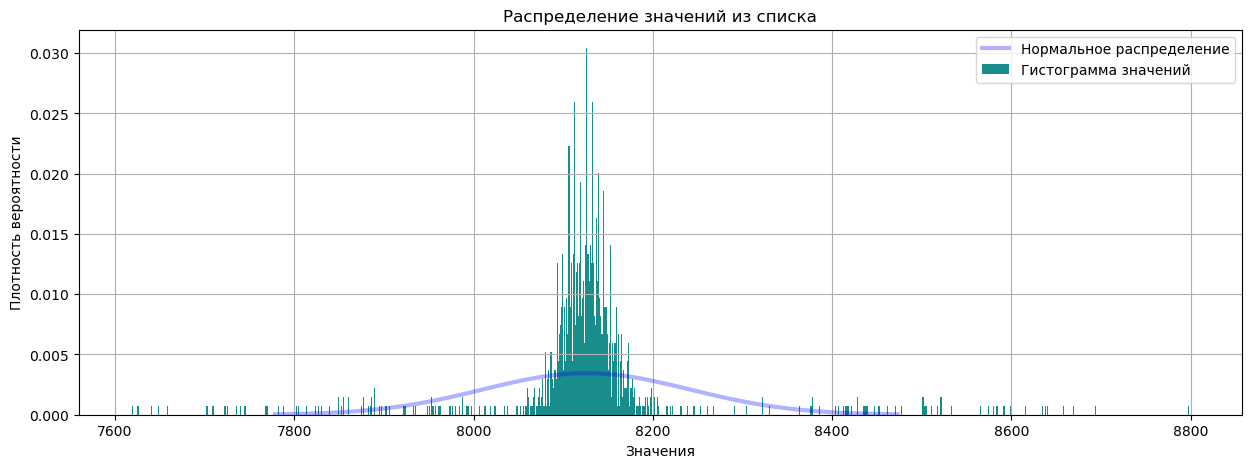

Эксцесс  8.747520639206703
Асимметрия  0.6055526474571659
Среднее значение пикселей: 8125.87489063867
Минимальное значение пикселей: 7619
Минимальное значение пикселей: 8798
Три наиболее часто встречающихся значения:
Значение: 8126, Частота: 26
Значение: 8137, Частота: 22
Значение: 8133, Частота: 21


In [15]:
from collections import Counter
from scipy.stats import kurtosis
from scipy.stats import skew
import statistics
import seaborn as sns
import scipy.stats as stats
%matplotlib inline
# Вычисление среднего и стандартного отклонения
mean = np.mean(listic34q) ######################################################################
std_dev = np.std(listic34q) ###############################################################################

# Генерация точек для построения нормального распределения
x = np.linspace(mean -3*std_dev, mean + 3*std_dev, 100)
y = stats.norm.pdf(x, mean, std_dev)


# Построение графика
plt.figure(figsize=(15, 5))
plt.plot(x, y, linewidth=3, color='b', label='Нормальное распределение', alpha=0.3)
plt.hist(listic34q, density=True, bins=1000, alpha=0.9, color='Teal', label='Гистограмма значений') ############################


plt.title('Распределение значений из списка')
plt.xlabel('Значения')
plt.ylabel('Плотность вероятности')
plt.legend()
plt.grid()
plt.show()
print("Эксцесс ", kurtosis(listic34q))######################################################
print("Асимметрия ", skew(listic34q))####################################################

average = statistics.mean(listic34q) #####################################################
print(f'Среднее значение пикселей: {average}') 

mi = min(listic34q)##################################################################
print(f'Минимальное значение пикселей: {mi}') 
ma = max(listic34q)###################################################################
print(f'Максимальное значение пикселей: {ma}') 

count = Counter(listic34q)  ##################################################################
# Получение трех наиболее распространенных значений и их частоты
most_common_three = count.most_common(3)
print("Три наиболее часто встречающихся значения:")
for value, freq in most_common_three:
    print(f'Значение: {value}, Частота: {freq}')


<h1 style="color:red;">11. СОВМЕЩЕНИЕ</h1>

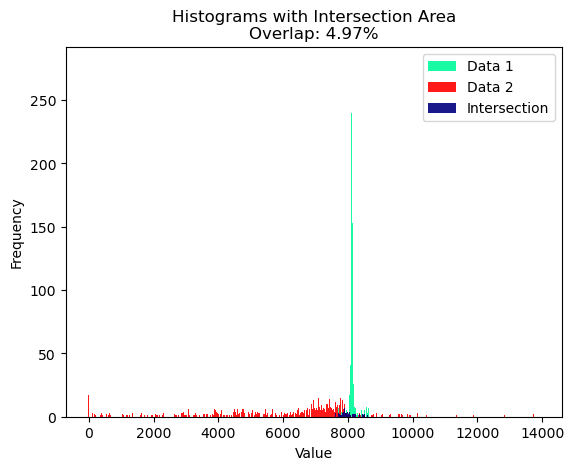

In [16]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def resample_list(data, target_size, seed):
    """Функция для ресемплирования одного списка до размера другого."""
    np.random.seed(seed)  # Установим seed для воспроизводимости
    return np.random.choice(data, target_size, replace=True)

def compute_histogram(data, bins, range):
    """Функция для построения гистограммы."""
    hist, bin_edges = np.histogram(data, bins=bins, range=range)
    return hist, bin_edges

def calculate_overlap_and_union(norm_hist, pat_hist):
    """Функция для вычисления объема пересечения и объема объединения."""
    overlap = np.minimum(norm_hist, pat_hist).sum()
    union = np.maximum(norm_hist, pat_hist).sum()
    return overlap, union

data1 = listic34q
data2 = listic34a

# Установим значение seed для воспроизводимости
seed = 42

# Ресемплирование списков до одинакового размера
target_size = max(len(data1), len(data2))
data1_resampled = resample_list(data1, target_size, seed)
data2_resampled = resample_list(data2, target_size, seed)

# Определение количества контейнеров (bins) для гистограммы
num_bins = 800

# Определение диапазона данных для гистограммы
data_range = (min(min(data1_resampled), min(data2_resampled)), max(max(data1_resampled), max(data2_resampled)))

# Построение гистограмм
hist1, bin_edges1 = compute_histogram(data1_resampled, bins=num_bins, range=data_range)
hist2, bin_edges2 = compute_histogram(data2_resampled, bins=num_bins, range=data_range)

# Находим минимальные значения гистограмм для зоны пересечения
intersection = np.minimum(hist1, hist2)

# Определяем ширину контейнера (бина)
bin_width = (bin_edges1[1] - bin_edges1[0])

# Вычисление пересечения и объединения гистограмм
overlap, union = calculate_overlap_and_union(hist1, hist2)

# Вычисление показателя степени пересечения в процентах
overlap_percentage = (overlap / union) * 100

# Построение графика
fig, ax = plt.subplots()

# Гистограмма для данных 1
ax.bar(bin_edges1[:-1], hist1, width=bin_width, color='MediumSpringGreen', alpha=0.9, label='Data 1')

# Гистограмма для данных 2
ax.bar(bin_edges2[:-1], hist2, width=bin_width, color='red', alpha=0.9, label='Data 2')

# Пересечение гистограмм
ax.bar(bin_edges1[:-1], intersection, width=bin_width, color='Navy', alpha=0.9, label='Intersection')

# Легенда и подписи

ax.legend()
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_title(f'Histograms with Intersection Area\nOverlap: {overlap_percentage:.2f}%')

plt.show()

#### 1. Красная часть - зона, включающая околопротезное пространство

#### 2. Зелёная часть - зона просто кости в стороне от протеза

#### 3. Синяя часть - пересечение гистограмм

<h4 style="color:red;">4. Значимый отрезок - левее зелёной зоны, говорящий о наличие условной "пустоты" по границе протеза (на самом снимке видна черная зона вокруг протеза) </h4>

<h1 style="color:Navy;">Экстраполяция плоскостных данных на объёмные</h1>

### Данные на выделенном участке с протезом по датафрейму ddf

In [17]:
# СПИСОК
listic34 = ddf.iloc[0,0] # Список элементов
print(listic34[0:10])
print(min(listic34))
print(max(listic34))
print(len(listic34))

[25869, 31245, 36461, 22807, 3917, 6151, 21106, 20889, 21125, 21867]
0
48455
2481


### Данные на обычном участке кости БЕЗ протеза по датафрейму ddff

In [18]:
# СПИСОК
listic34q = ddff.iloc[0,0] # Список элементов
print(listic34q[0:10])
print(min(listic34q))
print(max(listic34q))

[8161, 8177, 8145, 8180, 8173, 8153, 8417, 8059, 8169, 8159]
7619
8798


### Если участок без протеза - норма, то объём расшатывания - всё, что темнее 7619

In [19]:
# ОПРЕДЕЛЕНИЕ ТЕМНОЙ ПЛОЩАДИ ВОКРУГ НОЖКИ
import math
# Удаление элементов, превышающих 20000
listic34pat = [x for x in listic23 if x < 7619]

In [20]:
len(listic34pat)

914

### Объём протеза на участке

In [21]:
# ОПРЕДЕЛЕНИЕ СВЕТЛОЙ ПЛОЩАДИ НОЖКИ НА УЧАСТКЕ
import math
# Удаление элементов, превышающих 20000
listic34prot = [x for x in listic34 if x > 14000]

In [22]:
len(listic34prot)

1276

# Объём расшатывания (по соотношению площадей), в процентах

In [23]:
pc = len(listic34pat)/(len(listic34pat)+len(listic34prot))*100
pc

41.735159817351594

<h1 style="color:red;">Вокруг ножки много черноты</h1>

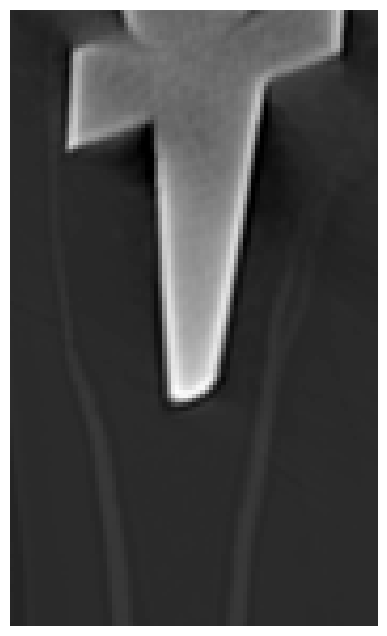

In [24]:
%matplotlib inline
gray_image282 = Image.open('34_239_bw.tiff')
plt.figure(figsize=(8, 8)) # Отображение изображения в оттенках серого
plt.imshow(gray_image282, cmap='gray')
plt.axis('off')
plt.show()

# Процент покрытия кости протезом как соотношение ярких пикселей протеза к общей площади сечения кости на длине протеза

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev
from PIL import Image, ImageDraw
import pandas as pd
import matplotlib
import tifffile

matplotlib.use('TkAgg')  # Используйте TkAgg backend
from matplotlib.backend_bases import MouseButton

ddfs = pd.DataFrame(columns=['pixels_inside_curve'])

image_path = '34_239_bw.tiff'  # Путь к изображению
image_array = tifffile.imread(image_path)  # Чтение изображения в numpy массив
image_array = image_array.astype(np.int32)
# Преобразование numpy массива в объект PIL Image для дальнейшего использования
image = Image.fromarray(image_array).convert("RGBA")

# Определение размера изображения
height, width = [146,87]

# список для хранения точек
points = []

def onclick(event):
    line_image = create_line_image()
    save_combined_image(line_image)

# Обработчик кликов
def onclick(event):
    global points
    if event.button == MouseButton.LEFT:
        # Добавление точки в список
        points.append([event.xdata, event.ydata])
        
        # Отображение точки на изображении
        ax.plot(event.xdata, event.ydata, 'ro', markersize=3)
        fig.canvas.draw()
        
        # Когда было выбрано 31 точек или больше, нарисовать кривую линию
        if len(points) == 41:
            if points[0] != points[-1]:
                points.append(points[0])
            line_image = draw_spline(points)  # Теперь передаем line_image
            save_combined_image(line_image)
            save_line_image(line_image)  # Добавляем этот вызов
            save_internal_pixels_list(points, width, height)  # Передаем ширину и высоту
            fig.canvas.mpl_disconnect(cid)

# Функция для рисования кривой линии
def draw_spline(points):
    points = np.array(points)
    x = points[:, 0]
    y = points[:, 1]
    
    # Используем сплайны для плавной линии через контрольные точки
    tck, u = splprep([x, y], s=0)
    u_new = np.linspace(u.min(), u.max(), 1000)
    x_new, y_new = splev(u_new, tck, ext=0)
    
    ax.plot(x_new, y_new, 'r-', lw=1.2)  # Рисование линии
    fig.canvas.draw()

    # Создаем пустое изображение для линии
    line_image = Image.new("RGBA", (width, height), (0, 0, 0, 0))
    save_combined_image(line_image)
    draw = ImageDraw.Draw(line_image)
    line_points = list(zip(x_new, y_new))
    draw.line(line_points, fill=(255, 0, 0, 255), width=1)
    return line_image

# Функция для сохранения изображения с нанесённой линией
def save_combined_image(line_image):
    # Копируем исходное изображение
    combined_image = image.copy()
    combined_image = Image.alpha_composite(combined_image, line_image)
    combined_image.save("34_239_bw_lines.tiff")
    #print("Изображение сохранено как 16_256_152_gilula_and_1_line.png")
    
# Функция для сохранения только линии в отдельный файл
def save_line_image(line_image):
    line_image.save("firs34_line_only.tiff")
    #print("Изображение линии сохранено как first_line_only.png")

# Функция для сохранения списка пикселей внутри замкнутой кривой линии
def save_internal_pixels_list(points, width, height):
    mask = Image.new("L", (width, height), 0)
    points = [(int(p[0]), int(p[1])) for p in points]
    ImageDraw.Draw(mask).polygon(points, outline=1, fill=1)
    mask = np.array(mask)
    
    internal_pixels = image_array[mask == 1]
    
    # Добавление списка пикселей в DataFrame
    ddfs.loc[len(ddfs)] = [internal_pixels.tolist()]
    print("Пиксели внутри замкнутой кривой линии добавлены в DataFrame")
    print(ddfs)

# Создание фигуры и отображение изображения
fig, ax = plt.subplots()
ax.imshow(image_array)

# Привязка обработчика кликов
cid = fig.canvas.mpl_connect('button_press_event', onclick)

# Запуск обработки событий и отображение окна
plt.show()

Пиксели внутри замкнутой кривой линии добавлены в DataFrame
                                 pixels_inside_curve
0  [36350, 19146, 20043, 19617, 19153, 20438, 211...


In [26]:
# СПИСОК
listic34s = ddfs.iloc[0,0] # Список элементов
print(listic34s[0:10])
print(min(listic34s))
print(max(listic34s))

[36350, 19146, 20043, 19617, 19153, 20438, 21195, 21053, 20623, 20374]
0
48455


In [27]:
len(listic34s)

5745

### Объём протеза на участке

In [29]:
# ОПРЕДЕЛЕНИЕ СВЕТЛОЙ ПЛОЩАДИ НОЖКИ НА УЧАСТКЕ
import math
# Удаление элементов, превышающих 20000
listic34spr = [x for x in listic34s if x > 14000]

In [30]:
len(listic34spr)

2626

In [ ]:
# Процент покрытия

In [32]:
pcs = len(listic34spr)/len(listic34s)*100
pcs

45.70931244560487